# Plot progeny composition

- We trained an SVM with the morphological descriptors of all the founders
- With it, we labeled all progeny based on their grain morphology
- We visualize how the progeny is distributed according to shape

**All the plots are colorblind-friendly**
- Plots made with ggplot

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(dplyr))

Define [colorblind-friendly palletes](https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40). 

In [2]:
# Bang Wong
colors_wong <- c('#E69F00','#52ADE0','#009E73','#F0E442',
                 '#0072B2','#D55E00','#CC79A7','#444444')

colors_def <- c('#D81B60', '#1E88E5', '#FFC107', '#004D40')

# Paul Tol
colors_tol <- c('#332288', '#117733', '#44AA99', '#88CCEE',
                '#DDCC77', '#CC6677')#, '#AA4499', '#882255')
colors_bright <- c('#4477AA', '#66CCEE', '#228833',
                   '#CCBB44', '#EE6677', '#AA3377')
#colors_high <- c('#F0E442', '#0005FF', '#D50000', '#FFFFFF')
#colors_high <- c('#F0E442', '#0072B2','#D55E00', '#FFFFFF')
colors_high <- c('#66CCEE', '#CCBB44','#AA3377', '#444444')

## Load data

- UMAP classification results for the progeny
- Rename a few accessions so that they require less characters (and thus fit better in the plots)


- To keep the plot coloring and stacking consistent, load the **combined, unscaled** classification results first.

In [4]:
setwd('~/documents/barley_stacks/preproc/progeny/unsupervised')
founders <- read.csv('../../../corrected_metadata.csv')
#founders_names_original <- sort(unique(founders$Founder))[-1]
founders_names_original <- levels(unique(founders$Founder))[-1]
founders_names <- founders_names_original
founders_names[5] <- 'CA Mariout'
founders_names[11] <- 'Good Delta'
founders_names[17] <- 'Maison Carree'
founders_names[24] <- 'Palmella Blue'
founders_names[28] <- 'WI Winter'
print(founders_names)

 [1] "Algerian"        "Alpha"           "Arequipa"        "Atlas"          
 [5] "CA Mariout"      "Club Mariout"    "Everest"         "Flynn"          
 [9] "Glabron"         "Golden Pheasant" "Good Delta"      "Han River"      
[13] "Hannchen"        "Horn"            "Lion"            "Lyallpur"       
[17] "Maison Carree"   "Manchuria"       "Meloy"           "Minia"          
[21] "Multan"          "Oderbrucker"     "Orel"            "Palmella Blue"  
[25] "Sandrel"         "Trebi"           "White Smyrna"    "WI Winter"      


In [55]:
# gen7_svm_combined_d158_T16_toposcaled.csv
gen <- 1
genn <- 18
d <- 158
TT <- 16

info_type <- 'combined'
scaled <- 'topounscaled'

filename <- paste('gen', gen, '_svm_', info_type, '_d', d,'_T',TT,'_',scaled,'.csv', sep='')
progeny <- read.csv(filename)

## Determine percentage of accession shape in a fixed generation

- Barplots are much better and clearer alternative than pie charts
- Never use pie charts


- The barplots are done twice, depending if you later want wide or narrow plots to fit in the manuscript/slides.

In [56]:
counts <- matrix(0, ncol=3, nrow=length(founders_names))
rownames(counts) <- founders_names_original

for(i in 1:length(founders_names_original))
    counts[i,1] = sum(progeny$Founder == founders_names_original[i])

counts[,2] <- (counts[,1]/dim(progeny)[1]*100)
ordered <- counts[base::order(counts[,1], decreasing=TRUE),]
ordered[,3] <- base::cumsum(ordered[,2])
rownames(ordered) <- founders_names[rank(rownames(ordered))]
df <- as.data.frame(ordered)
df$Line <- rownames(df)
df$Line <- factor(df$Line, levels=founders_names)

In [57]:
if((gen == 1) & (info_type=='combined') & (scaled == 'topounscaled')){
    print('oh')
    genotypes <- base::rev(base::levels(stats::reorder(df$Line, df$V2)))
    fcolors <- rep(colors_wong, length.out = nrow(df))   
}

In [58]:
df$Line <- factor(df$Line, levels=genotypes)

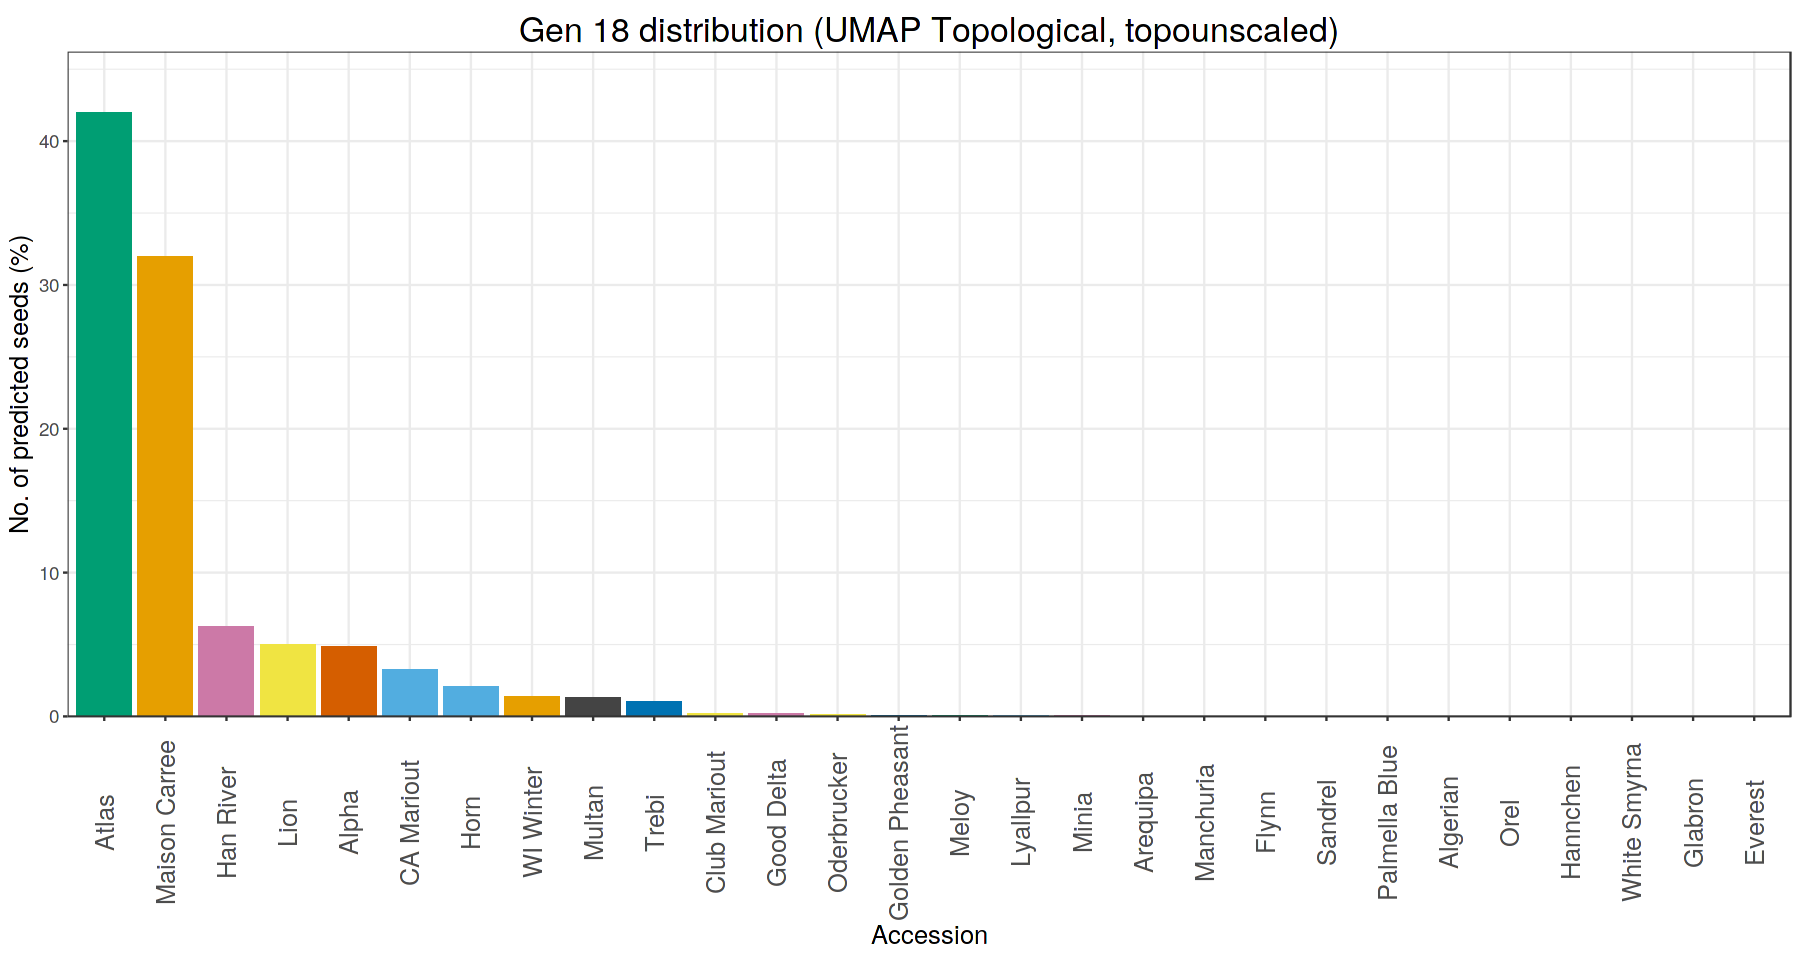

In [59]:
options(repr.plot.width=15, repr.plot.height=8)

titlename <- paste('Gen ', genn, ' distribution (UMAP ', stringr::str_to_title(info_type),', ', scaled,')', sep='')

p <- ggplot2::ggplot(df, aes(x=stats::reorder(Line, -V2), y=V2)) + 
     geom_bar(aes(fill=Line), stat='identity') +
     scale_fill_manual(values = fcolors) +
     theme_bw() +
     scale_y_continuous(expand = expansion(mult = c(0, .1))) +
     theme(plot.title = element_text(hjust = 0.5, vjust = 0, size=20),
            axis.text.x = element_text(size = 15, hjust = 0.5, vjust=0.5, angle=90),
            axis.text.y = element_text(size = 11),
            axis.title = element_text(size=15),
            legend.position = 'none') +
      ylab('No. of predicted seeds (%)') +
      ggtitle(titlename) +
      xlab('Accession') 
p

In [60]:
w <- 8
h <- 9

filename <- paste('histogram_',info_type, '_gen',gen,'_d',d,'_T',TT,'_',scaled,'_vert',sep='')
print(filename)
ggplot2::ggsave(paste(filename, '.pdf', sep=''), plot=p, device='pdf', width=w, height=h)
ggplot2::ggsave(paste(filename, '.png', sep=''), plot=p, device='png', width=8, height=9)

[1] "histogram_topological_gen1_d158_T16_topounscaled_vert"


In [61]:
w <- 12
h <- 6

filename <- paste('histogram_',info_type, '_gen',gen,'_d',d,'_T',TT,'_',scaled,'_horz',sep='')

ggplot2::ggsave(paste(filename, '.pdf', sep=''), plot=p, device='pdf', width=w, height=h)
ggplot2::ggsave(paste(filename, '.png', sep=''), plot=p, device='png', width=w, height=h)

## Determine percentage for individual lines

- With `dplyr::arrange`, we sort the x-axis (line selection) according to their percentage of _Maison Carre_

- The white vertical streaks are rendering artifacts when these appear at irregular intervals.

- The vector-based PDFs do not show irregular streaks.

In [62]:
selection <- sort(unique(progeny$Selection))
counts <- matrix(0, nrow=length(selection), ncol=length(founders_names))

for(i in 1:nrow(counts)){
    foo <- progeny[progeny$Selection == selection[i], ]
    for(j in 1:ncol(counts)){
        counts[i,j] <- (sum(foo$Founder == founders_names_original[j])/nrow(foo)*100)
    }
}

dg <- as.data.frame(counts)
colnames(dg) <- founders_names
rownames(dg) <- selection
dg$Selection <- rownames(dg)

In [63]:
dga <- dplyr::arrange(dg, dplyr::desc(data.frame(base::rowSums(dg[genotypes[1:1]]))))
dga$Selection <- factor(dga$Selection, levels=dga$Selection[1:nrow(dga)])
dga <- dplyr::select(dga, c(colnames(dga)[rank(genotypes)], 'Selection'))
dgm <- reshape2::melt(dga, id.vars='Selection', variable.name='Line', value.name='Percentage')

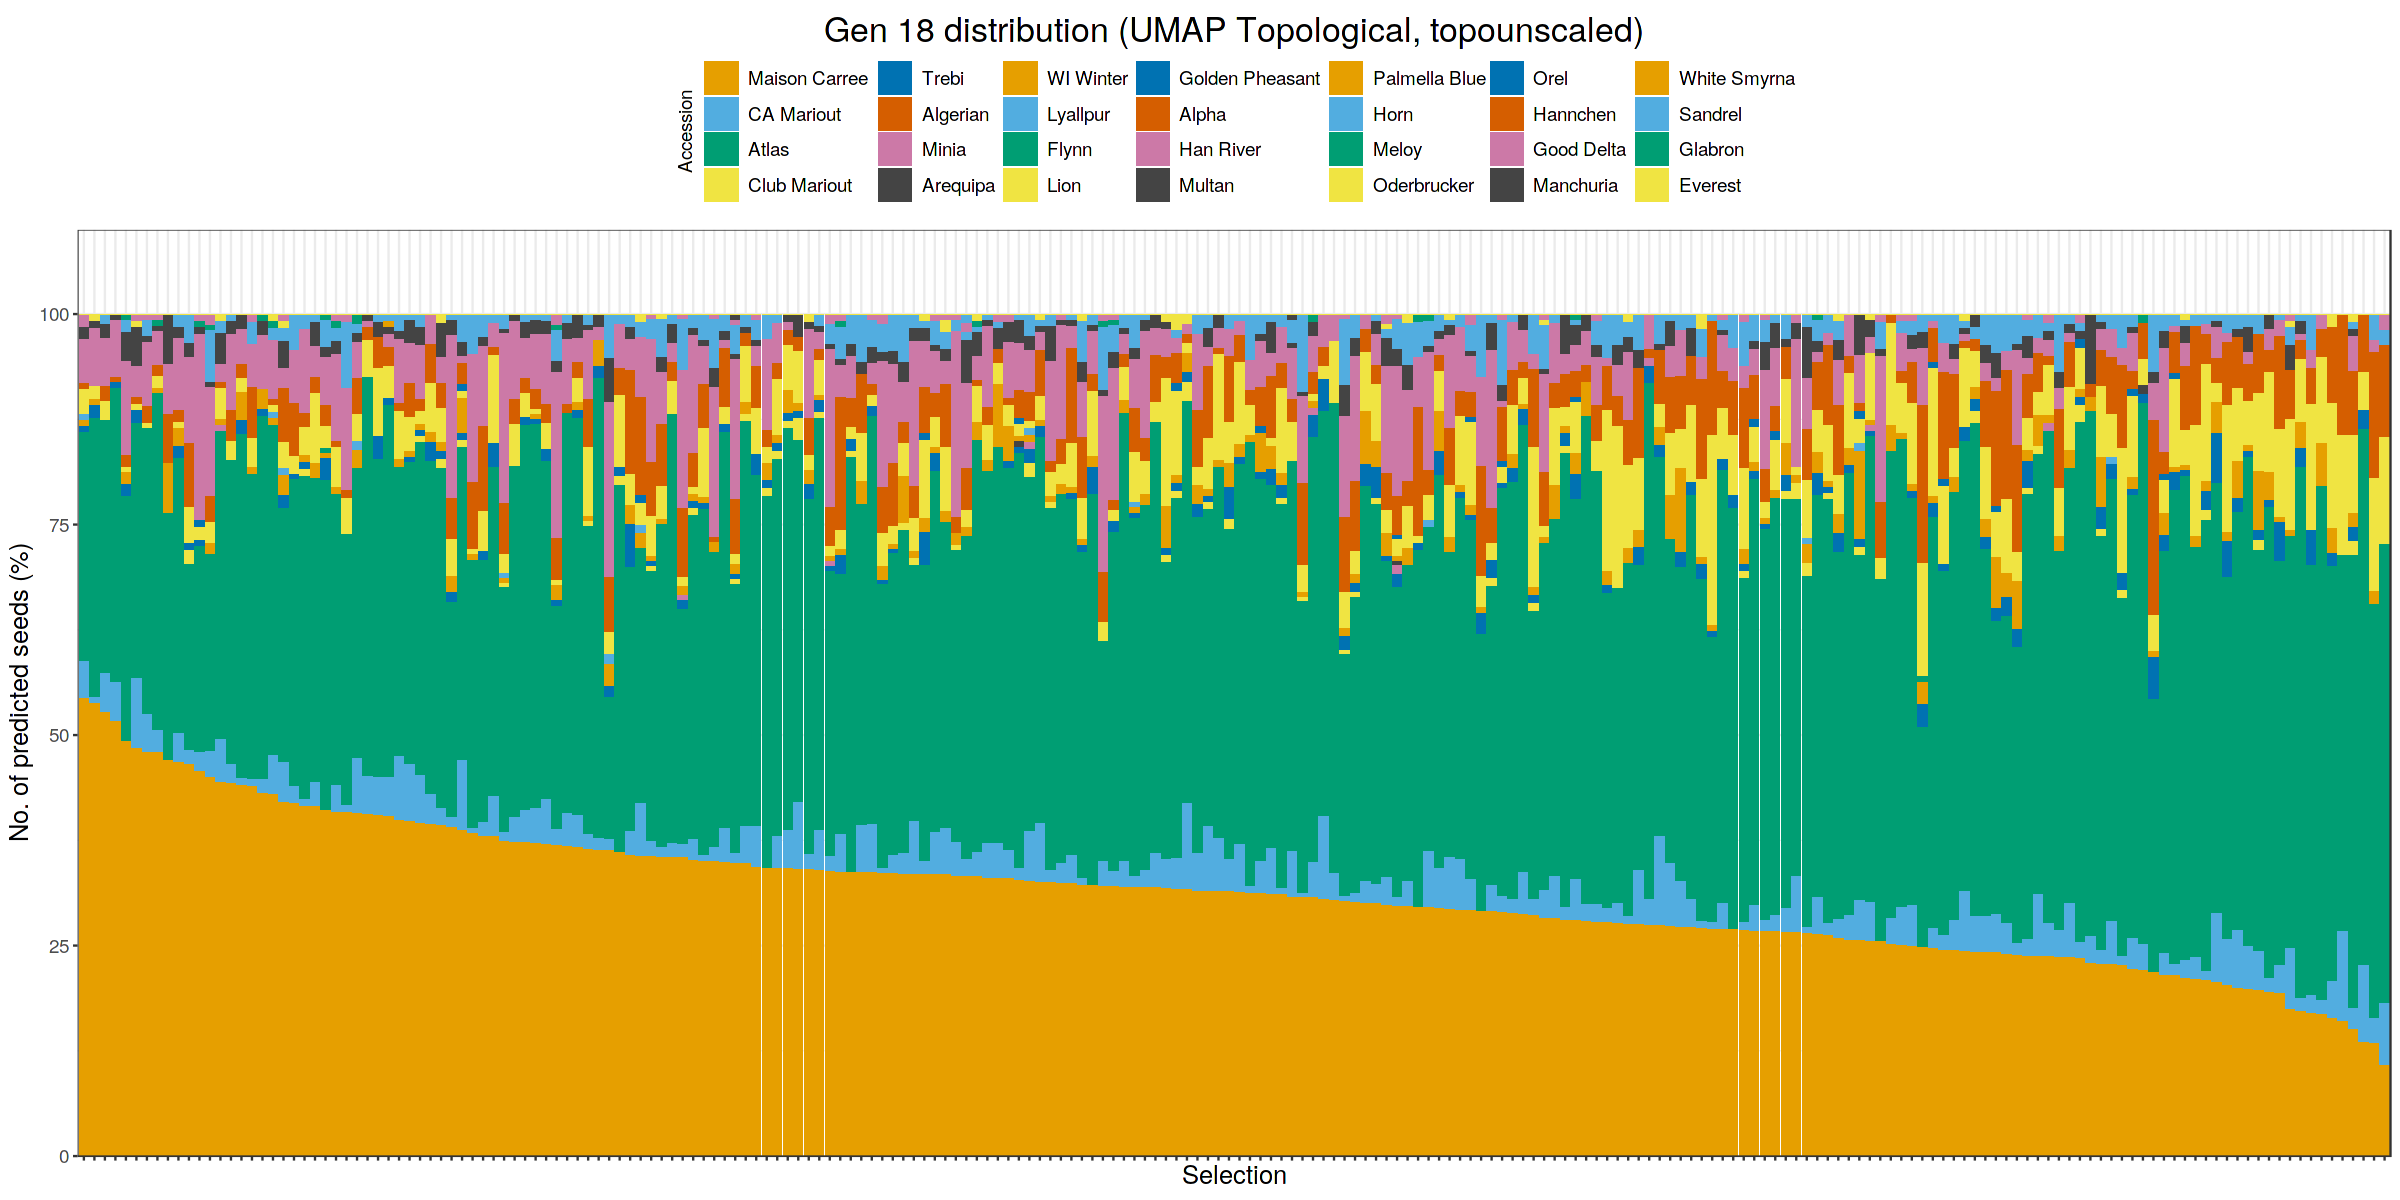

In [64]:
options(repr.plot.width=20, repr.plot.height=10)

titlename <- paste('Gen ', genn, ' distribution (UMAP ', stringr::str_to_title(info_type),', ', scaled,')', sep='')

p <- ggplot(dgm, aes(x=Selection, y=Percentage)) +
     geom_col(aes(fill=Line), position = position_stack(reverse = TRUE))+
     scale_fill_manual(values = fcolors, guide = guide_legend(ncol = 7)) +
     theme_bw() +
     scale_y_continuous(expand = expansion(mult = c(0, .1))) +
     theme(plot.title = element_text(hjust = 0.5, vjust = 0, size=20),
            #axis.text.x = element_text(size = 11, angle=90),
            axis.text.x = element_blank(),
            axis.text.y = element_text(size = 11),
            axis.title = element_text(size=15),
            legend.text = element_text(size=11),
            legend.key.size = unit(0.75, 'cm'),
            legend.title = element_text(angle=90, vjust=0.5, hjust=0.5),
            legend.position = "top"
            ) +
      ylab('No. of predicted seeds (%)') +
      ggtitle(titlename) +
      xlab('Selection') +
      labs(fill = "Accession")
p

In [65]:
w = 14
h = 8
filename <- paste('selection_',info_type,'_gen',gen,'_d',d,'_T',TT,'_',scaled, sep='')
print(filename)
ggplot2::ggsave(paste(filename, '.pdf', sep=''), plot=p, device='pdf', width=w, height=h)
ggplot2::ggsave(paste(filename, '.png', sep=''), plot=p, device='png', width=w, height=h)

[1] "selection_topological_gen1_d158_T16_topounscaled"


# Progeny Comparison

## Compare accession shape percentage overall changes across generations

- Load both generations simultaneously

In [166]:
# gen7_svm_combined_d158_T16_toposcaled.csv
info_type <- 'topological'
scaled <- 'topounscaled'

gen <- 1
genn <- 18

filename <- paste('gen', gen, '_svm_', info_type, '_d', d,'_T',TT,'_',scaled,'.csv', sep='')
progeny1 <- read.csv(filename)

In [167]:
# gen7_svm_combined_d158_T16_toposcaled.csv
gen <- 7
genn <- 58

filename <- paste('gen', gen, '_svm_', info_type, '_d', d,'_T',TT,'_',scaled,'.csv', sep='')
progeny7 <- read.csv(filename)

In [168]:
counts <- matrix(0, ncol=3, nrow=length(founders_names))
rownames(counts) <- founders_names_original
for(i in 1:length(founders_names_original))
    counts[i,1] = sum(progeny1$Founder == founders_names_original[i])

counts[,2] <- (counts[,1]/dim(progeny1)[1]*100)
ordered <- counts[base::order(counts[,1], decreasing=TRUE),]
ordered[,3] <- base::cumsum(ordered[,2])
rownames(ordered) <- founders_names[rank(rownames(ordered))]
df1 <- as.data.frame(ordered)
df1$Line <- rownames(df1)
df1$Line <- factor(df1$Line, levels=founders_names)
df1$Line <- factor(df1$Line, levels=genotypes)
df1$Gen <- 18

In [169]:
for(i in 1:length(founders_names_original))
    counts[i,1] = sum(progeny7$Founder == founders_names_original[i])

counts[,2] <- (counts[,1]/dim(progeny7)[1]*100)
ordered <- counts[base::order(counts[,1], decreasing=TRUE),]
ordered[,3] <- base::cumsum(ordered[,2])
rownames(ordered) <- founders_names[rank(rownames(ordered))]
df7 <- as.data.frame(ordered)
df7$Line <- rownames(df7)
df7$Line <- factor(df7$Line, levels=founders_names)
df7$Line <- factor(df7$Line, levels=genotypes)
df7$Gen <- 58

In [170]:
df <- rbind(df1, df7)
df$Gen = factor(df$Gen, levels=c(58,18))

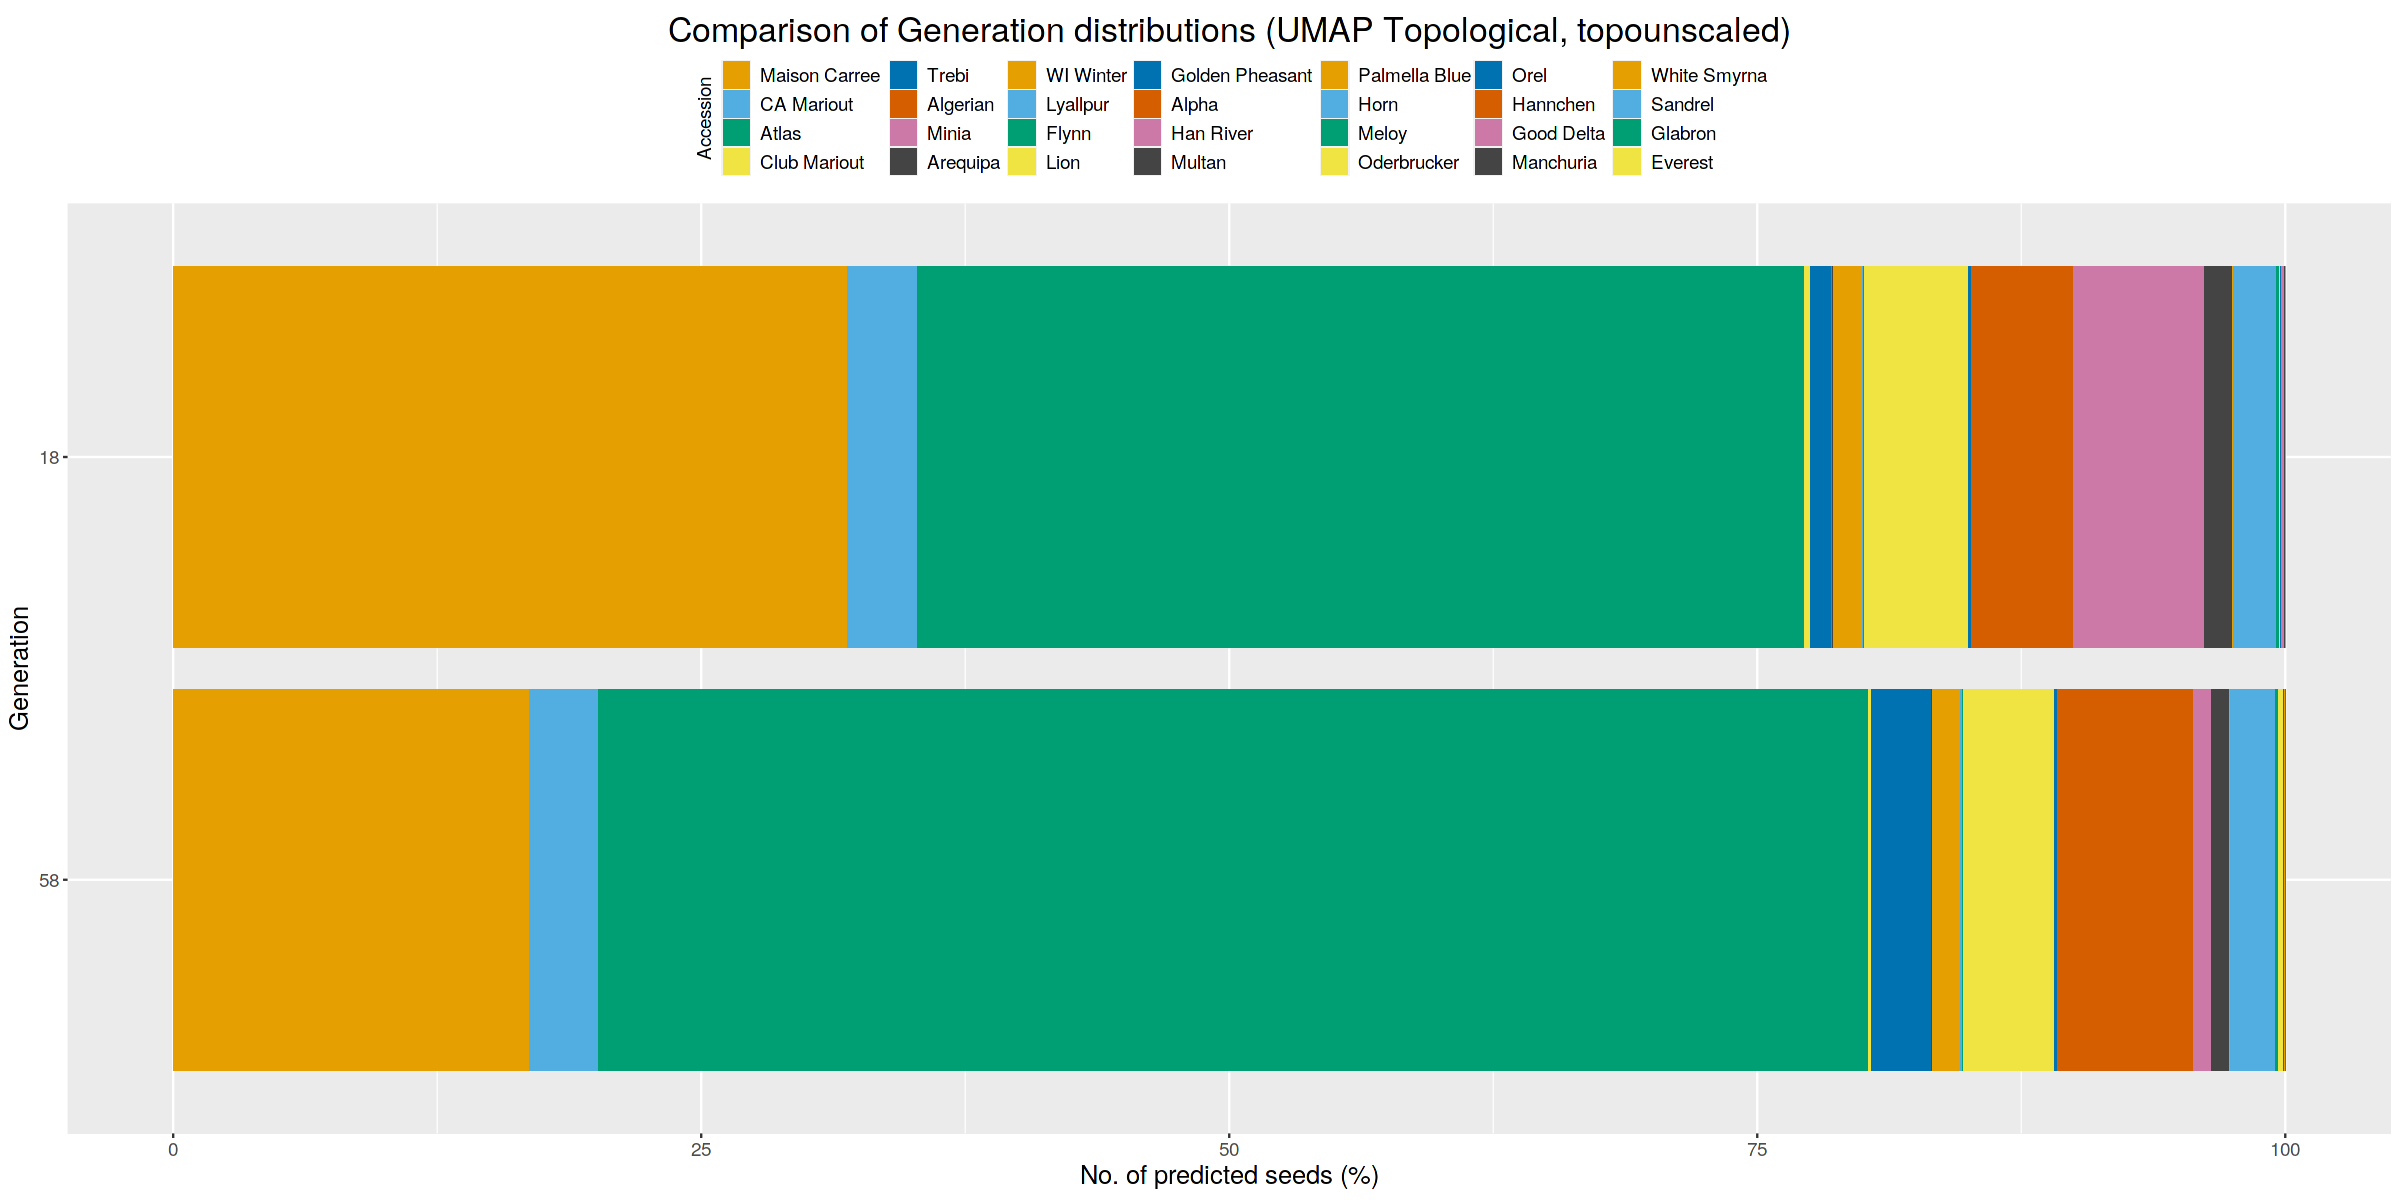

In [171]:
titlename <- paste('Comparison of Generation distributions (UMAP ', 
                    stringr::str_to_title(info_type), ', ', 
                    scaled, ')', sep='')

p <- ggplot2::ggplot(df, aes(y=Gen, x=V2)) +
    geom_col(aes(fill=Line), position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = fcolors, guide = guide_legend(ncol = 7)) +
    theme(plot.title = element_text(hjust = 0.5, vjust = 0, size=20),
            axis.text.x = element_text(size = 11, angle=0),
            #axis.text.x = element_blank(),
            axis.text.y = element_text(size = 11),
            axis.title = element_text(size=15),
            legend.text = element_text(size=11),
            legend.title = element_text(angle=90, vjust=0.5, hjust=0.5),
            legend.position = "top"
            ) +
    xlab('No. of predicted seeds (%)') +
    ggtitle(titlename) +
    ylab('Generation') + 
    labs(fill = "Accession")
p

In [172]:
w = 10
h = 3
filename <- paste('comparison_generations_',info_type,'_',scaled,'_d',d,'_T',TT,'_horz', sep='')
print(filename)
ggplot2::ggsave(paste(filename, '.pdf', sep=''), plot=p, device='pdf', width=w, height=h)
ggplot2::ggsave(paste(filename, '.png', sep=''), plot=p, device='png', width=w, height=h)

[1] "comparison_generations_topological_topounscaled_d158_T16_horz"


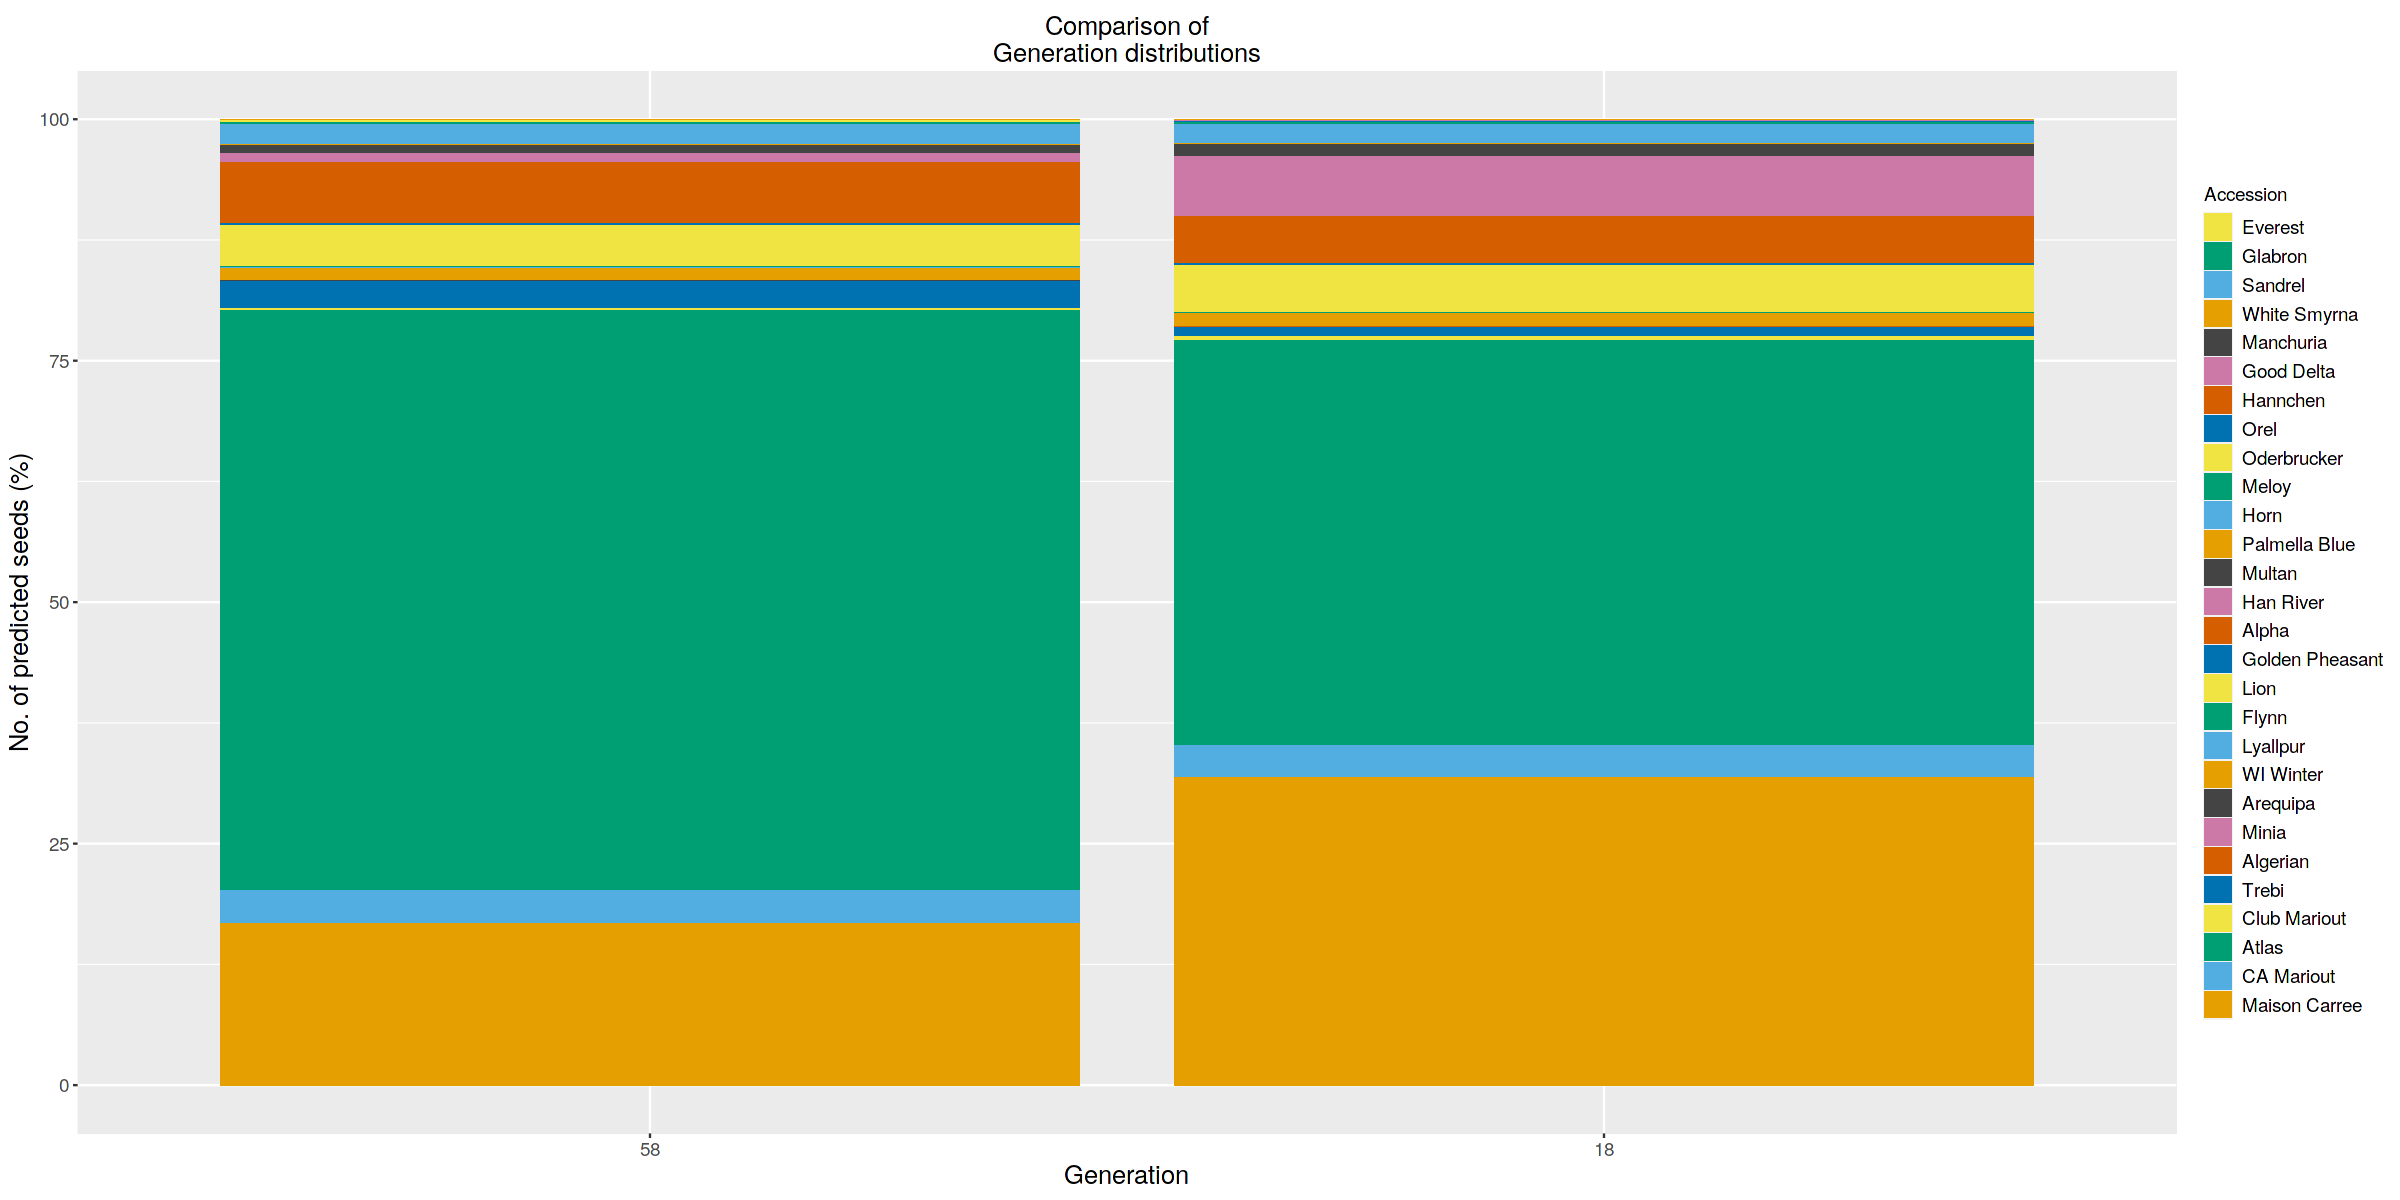

In [173]:
titlename <- 'Comparison of\nGeneration distributions'

p <- ggplot2::ggplot(df, aes(x=Gen, y=V2)) +
    geom_col(aes(fill=Line), position = position_stack(reverse = TRUE)) +
    scale_fill_manual(values = fcolors, guide = guide_legend(ncol = 1, reverse=TRUE)) +
    theme(plot.title = element_text(hjust = 0.5, vjust = 0, size=15),
            axis.text.x = element_text(size = 11, angle=0),
            #axis.text.x = element_blank(),
            axis.text.y = element_text(size = 11),
            axis.title = element_text(size=15),
            legend.text = element_text(size=11),
            #legend.title = element_text(title = 'd'),
            #legend.key.size = unit(0.75, 'cm'),
            legend.position = "right"
            ) +
    ylab('No. of predicted seeds (%)') +
    ggtitle(titlename) +
    xlab('Generation') +
    #guides(fill = guide_legend(reverse = TRUE, ncol=1)) +
    labs(fill = "Accession")
p

In [174]:
w = 4
h = 8
filename <- paste('comparison_generations_',info_type,'_',scaled,'_d',d,'_T',TT,'_vert', sep='')
ggplot2::ggsave(paste(filename, '.pdf', sep=''), plot=p, device='pdf', width=w, height=h)
ggplot2::ggsave(paste(filename, '.png', sep=''), plot=p, device='png', width=w, height=h)

## Visualize better the differences across generations

In [175]:
diff <- data.frame(val = df7$V2 - df1$V2, Line=genotypes)
diff$Line <- factor(diff$Line, levels=genotypes)

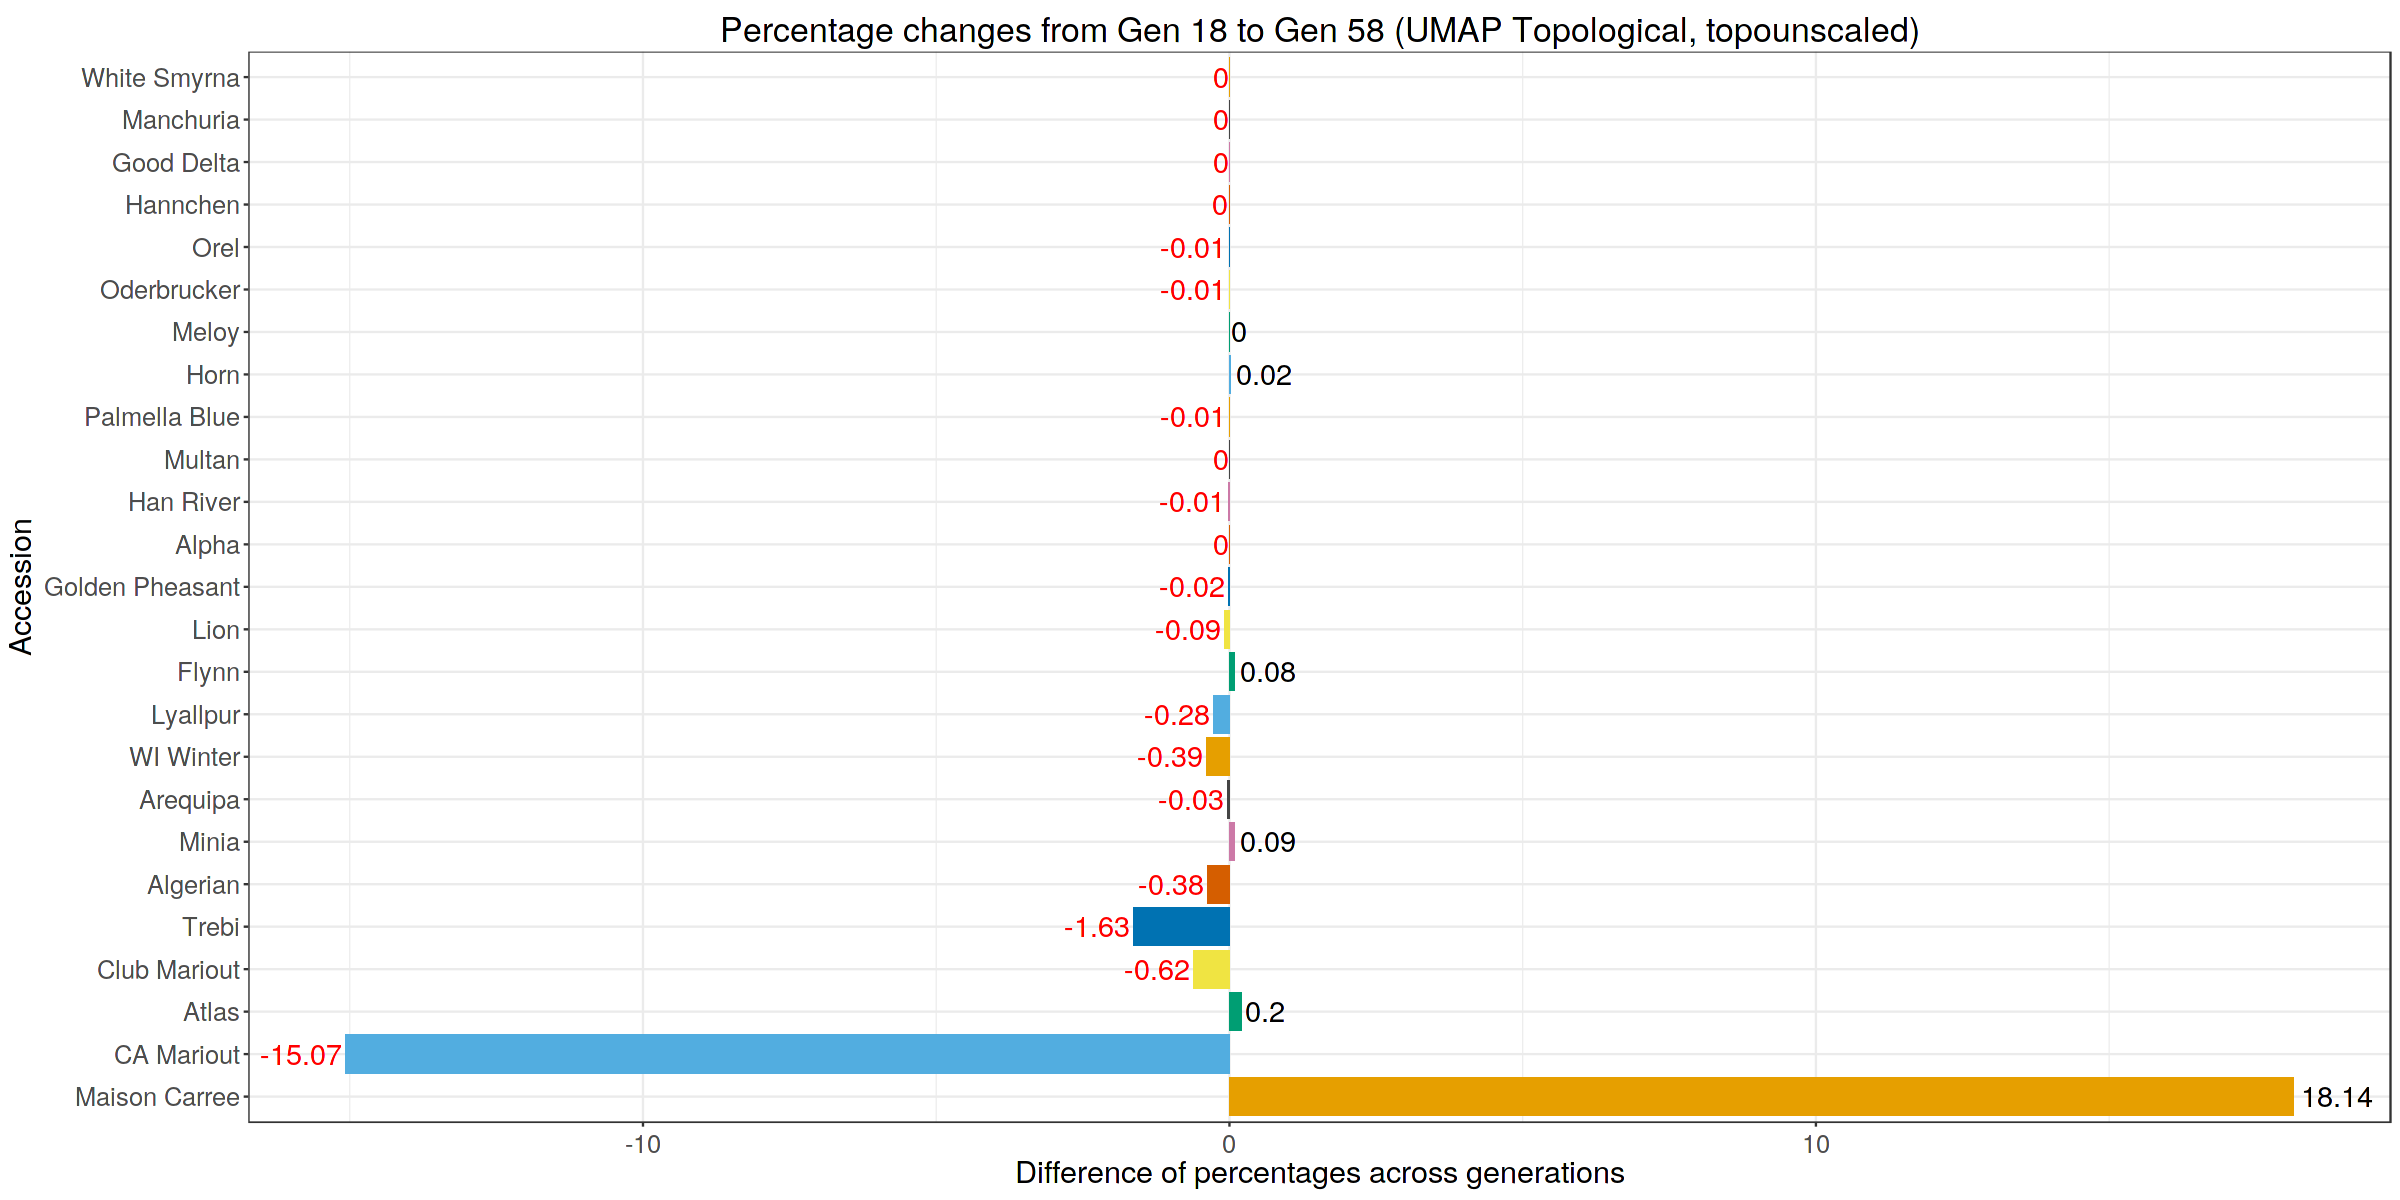

In [176]:
cols <- ifelse(diff$val[1:25]>0, 'black', 'red')
#cols[2] <- 'yellow'
#cols[26] <- 'black'

options(repr.plot.width=20, repr.plot.height=10)
titlename <- paste('Percentage changes from Gen 18 to Gen 58 (UMAP ',
                   stringr::str_to_title(info_type), ', ', 
                   scaled, ')', sep='')

p <- ggplot2::ggplot(diff[1:25,], aes(x=val, y=Line)) + 
     geom_col(aes(fill=Line)) +
     scale_fill_manual(values = fcolors) +
     theme_bw() +
     #scale_x_continuous(expand = expansion(mult = c(0, 0.01)), limits=c(-5,10.3)) +
     geom_text(aes(label = paste(round(val,2)),
                   hjust = ifelse(val > 0, -0.1, 1.05)),
               size = 6,
               color = cols) +
     #annotate('Gen 18')
     theme(plot.title = element_text(hjust = 0.5, vjust = 0, size=20),
            axis.text.x = element_text(size = 15, hjust = 0.5, vjust=0.5),
            axis.text.y = element_text(size = 15),
            axis.title = element_text(size=18),
            axis.title.x = element_text(hjust=0.5),
            legend.position = 'none') +
      ylab('Accession') +
      ggtitle(titlename) +
      xlab('Difference of percentages across generations') 
p

In [177]:
w = 16
h = 7.5
filename <- paste('diff_',info_type, '_', scaled, '_d', d,'_T',TT,sep='')
ggplot2::ggsave(paste(filename, '.pdf', sep=''), plot=p, device='pdf', width=w, height=h)
ggplot2::ggsave(paste(filename, '.png', sep=''), plot=p, device='png', width=w, height=h)

# Individual line comparison

- Compare how individual lines changed from one generation to another.
- Only able to compare those lines that persisted all the way to $F_{58}$ in `selection7`.

In [178]:
selection1 <- sort(unique(progeny1$Selection))
selection7 <- sort(unique(progeny7$Selection))

In [181]:
counts1 <- matrix(0, nrow=length(selection7), ncol=length(founders_names))

for(i in 1:nrow(counts1)){
    foo <- progeny1[progeny1$Selection == selection7[i], ]
    for(j in 1:ncol(counts1)){
        counts1[i,j] <- (sum(foo$Founder == founders_names_original[j])/nrow(foo)*100)
    }
}
dg <- as.data.frame(counts1)

In [185]:
colnames(dg) <- founders_names
rownames(dg) <- selection7
dg$Selection <- rownames(dg)

dga <- dplyr::arrange(dg, dplyr::desc(data.frame(base::rowSums(dg[genotypes[1:1]]))))
dga$Selection <- factor(dga$Selection, levels=dga$Selection[1:nrow(dga)])
dga <- dplyr::select(dga, c(colnames(dga)[rank(genotypes)], 'Selection'))

In [183]:
dgm1 <- reshape2::melt(dga, id.vars='Selection', variable.name='Line', value.name='Percentage')
dgm1$Gen <- 18

In [184]:
counts7 <- matrix(0, nrow=length(selection7), ncol=length(founders_names))

for(i in 1:nrow(counts7)){
    foo <- progeny7[progeny7$Selection == selection7[i], ]
    for(j in 1:ncol(counts7)){
        counts7[i,j] <- (sum(foo$Founder == founders_names_original[j])/nrow(foo)*100)
    }
}
dg <- as.data.frame(counts7)

In [185]:
colnames(dg) <- founders_names
rownames(dg) <- selection7
dg$Selection <- rownames(dg)

dga <- dplyr::arrange(dg, dplyr::desc(data.frame(base::rowSums(dg[genotypes[1:1]]))))
dga$Selection <- factor(dga$Selection, levels=dga$Selection[1:nrow(dga)])
dga <- dplyr::select(dga, c(colnames(dga)[rank(genotypes)], 'Selection'))

In [186]:
dgm7 <- reshape2::melt(dga, id.vars='Selection', variable.name='Line', value.name='Percentage')
dgm7$Gen <- 58

In [187]:
dgm <- rbind(dgm1, dgm7)
dgm$Gen <- factor(dgm$Gen, levels = c(18,58))
dgm$Selection <- factor(dgm$Selection, levels = selection7)

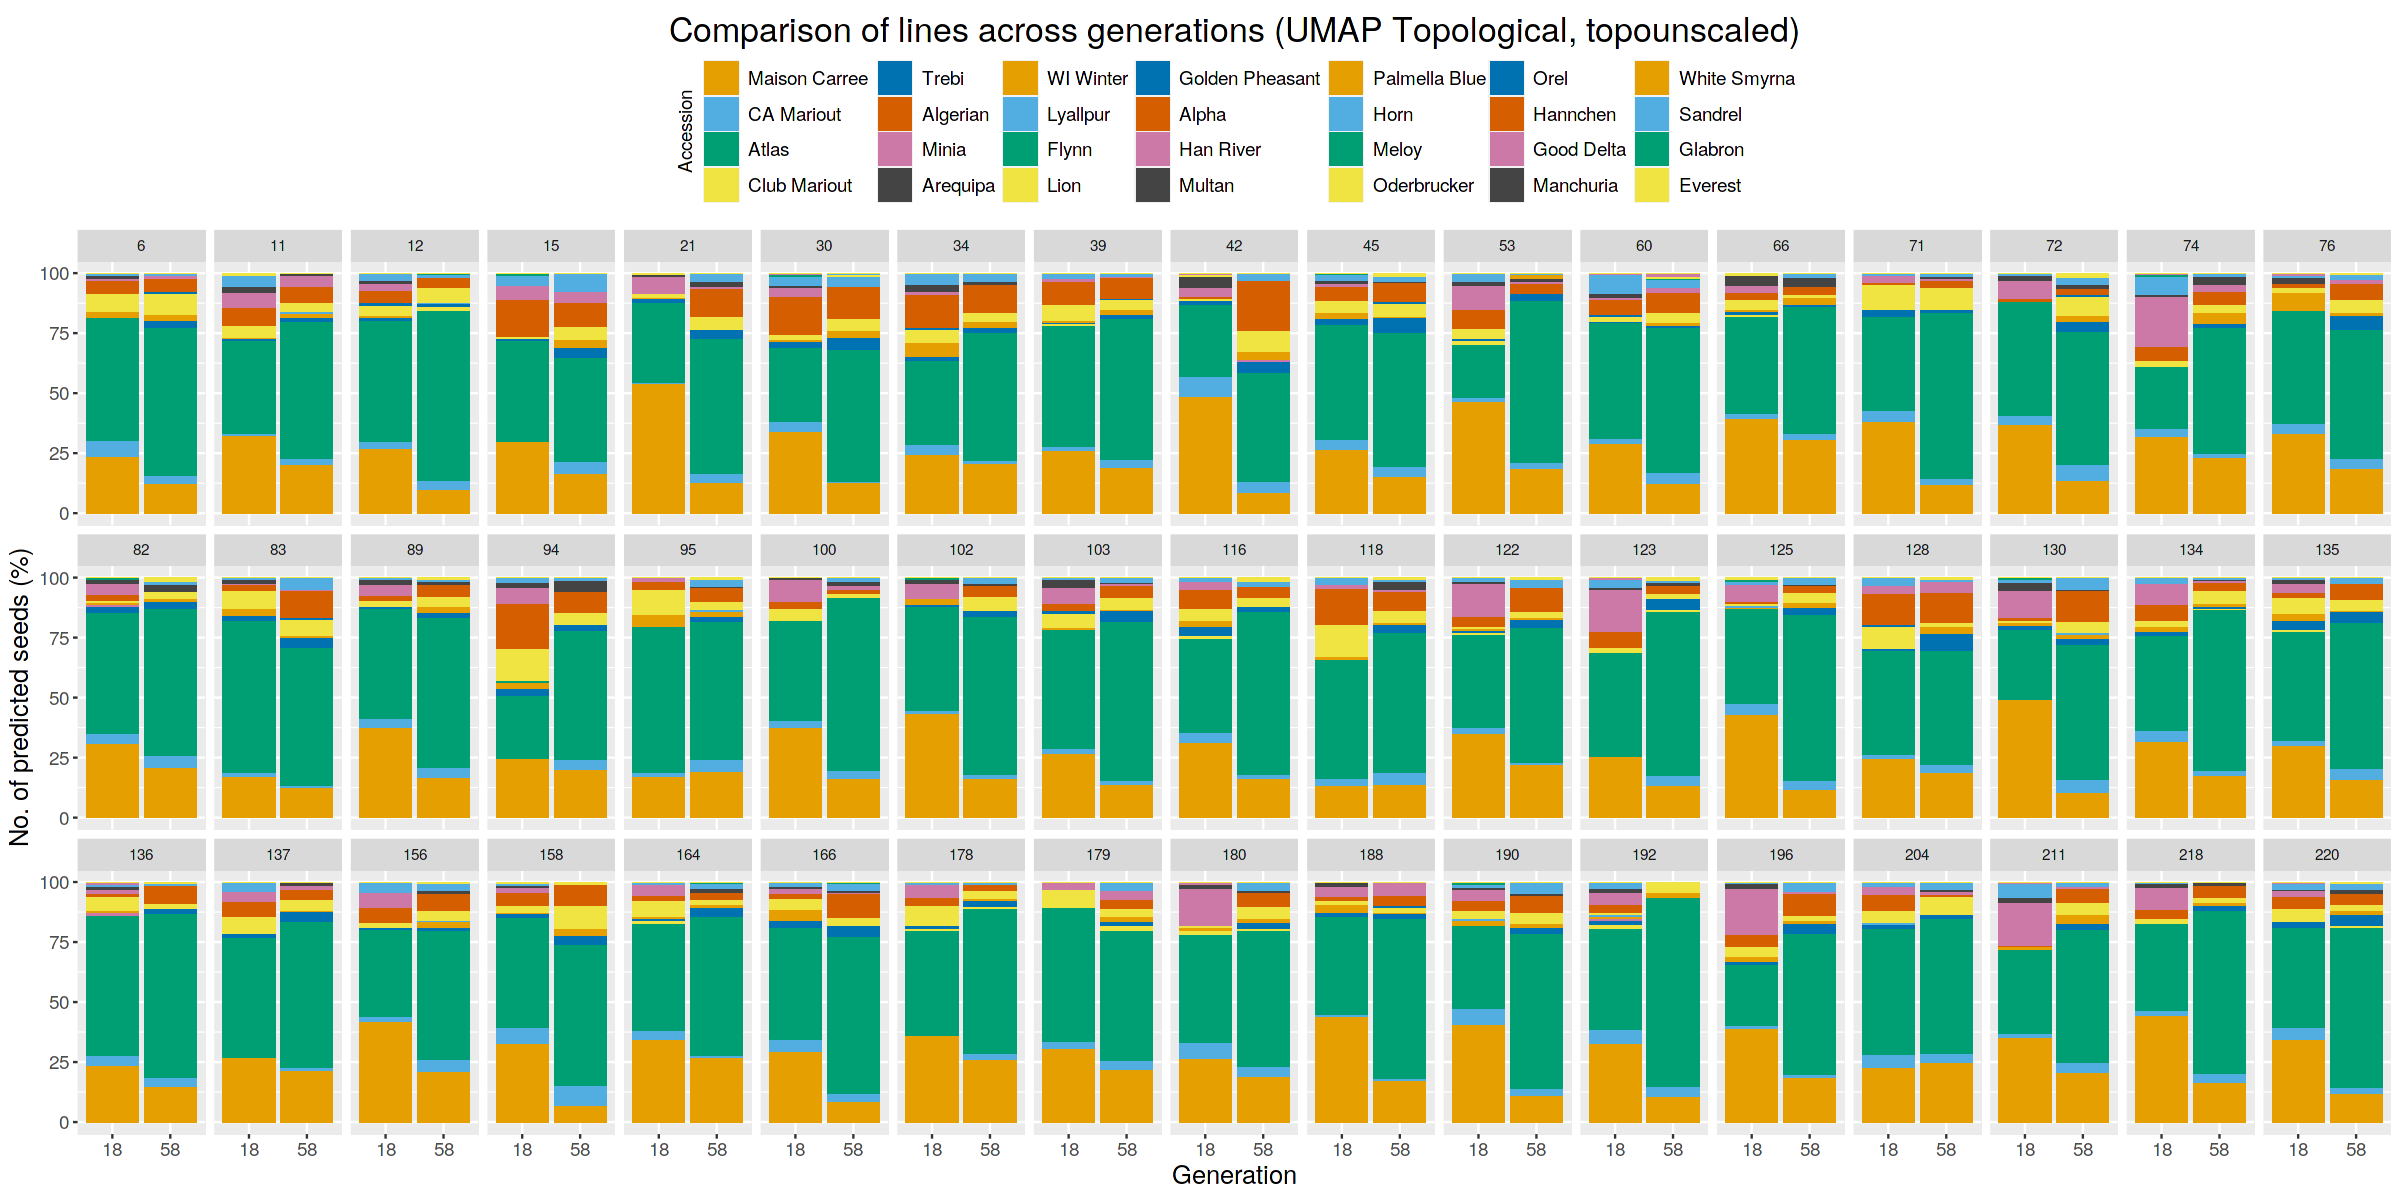

In [188]:
titlename <- paste('Comparison of lines across generations (UMAP ', 
                    stringr::str_to_title(info_type), ', ', 
                    scaled, ')', sep='')

p <- ggplot2::ggplot(dgm, aes(y=Percentage, x=Gen)) +
    geom_col(aes(fill=Line), position = position_stack(reverse = TRUE)) +
    facet_wrap(facet=vars(Selection), ncol=17) +
    scale_fill_manual(values = fcolors, guide = guide_legend(ncol = 7)) +
    theme(plot.title = element_text(hjust = 0.5, vjust = 0, size=20),
            axis.text.x = element_text(size = 11, angle=0),
            #axis.text.x = element_blank(),
            axis.text.y = element_text(size = 11),
            axis.title = element_text(size=15),
            legend.text = element_text(size=11),
            legend.key.size = unit(0.75, 'cm'),
            legend.title = element_text(angle=90, vjust=0.5, hjust=0.5),
            legend.position = "top"
            ) +
    ylab('No. of predicted seeds (%)') +
    ggtitle(titlename) +
    xlab('Generation') +
    labs(fill = "Accession")
p

In [189]:
w = 16
h = 10
filename <- paste('comparison_lines_',info_type,'_',scaled,'_d',d,'_T',TT,'_horz', sep='')
print(filename)
ggplot2::ggsave(paste(filename, '.pdf', sep=''), plot=p, device='pdf', width=w, height=h)
ggplot2::ggsave(paste(filename, '.png', sep=''), plot=p, device='png', width=w, height=h)

[1] "comparison_lines_topological_topounscaled_d158_T16_horz"


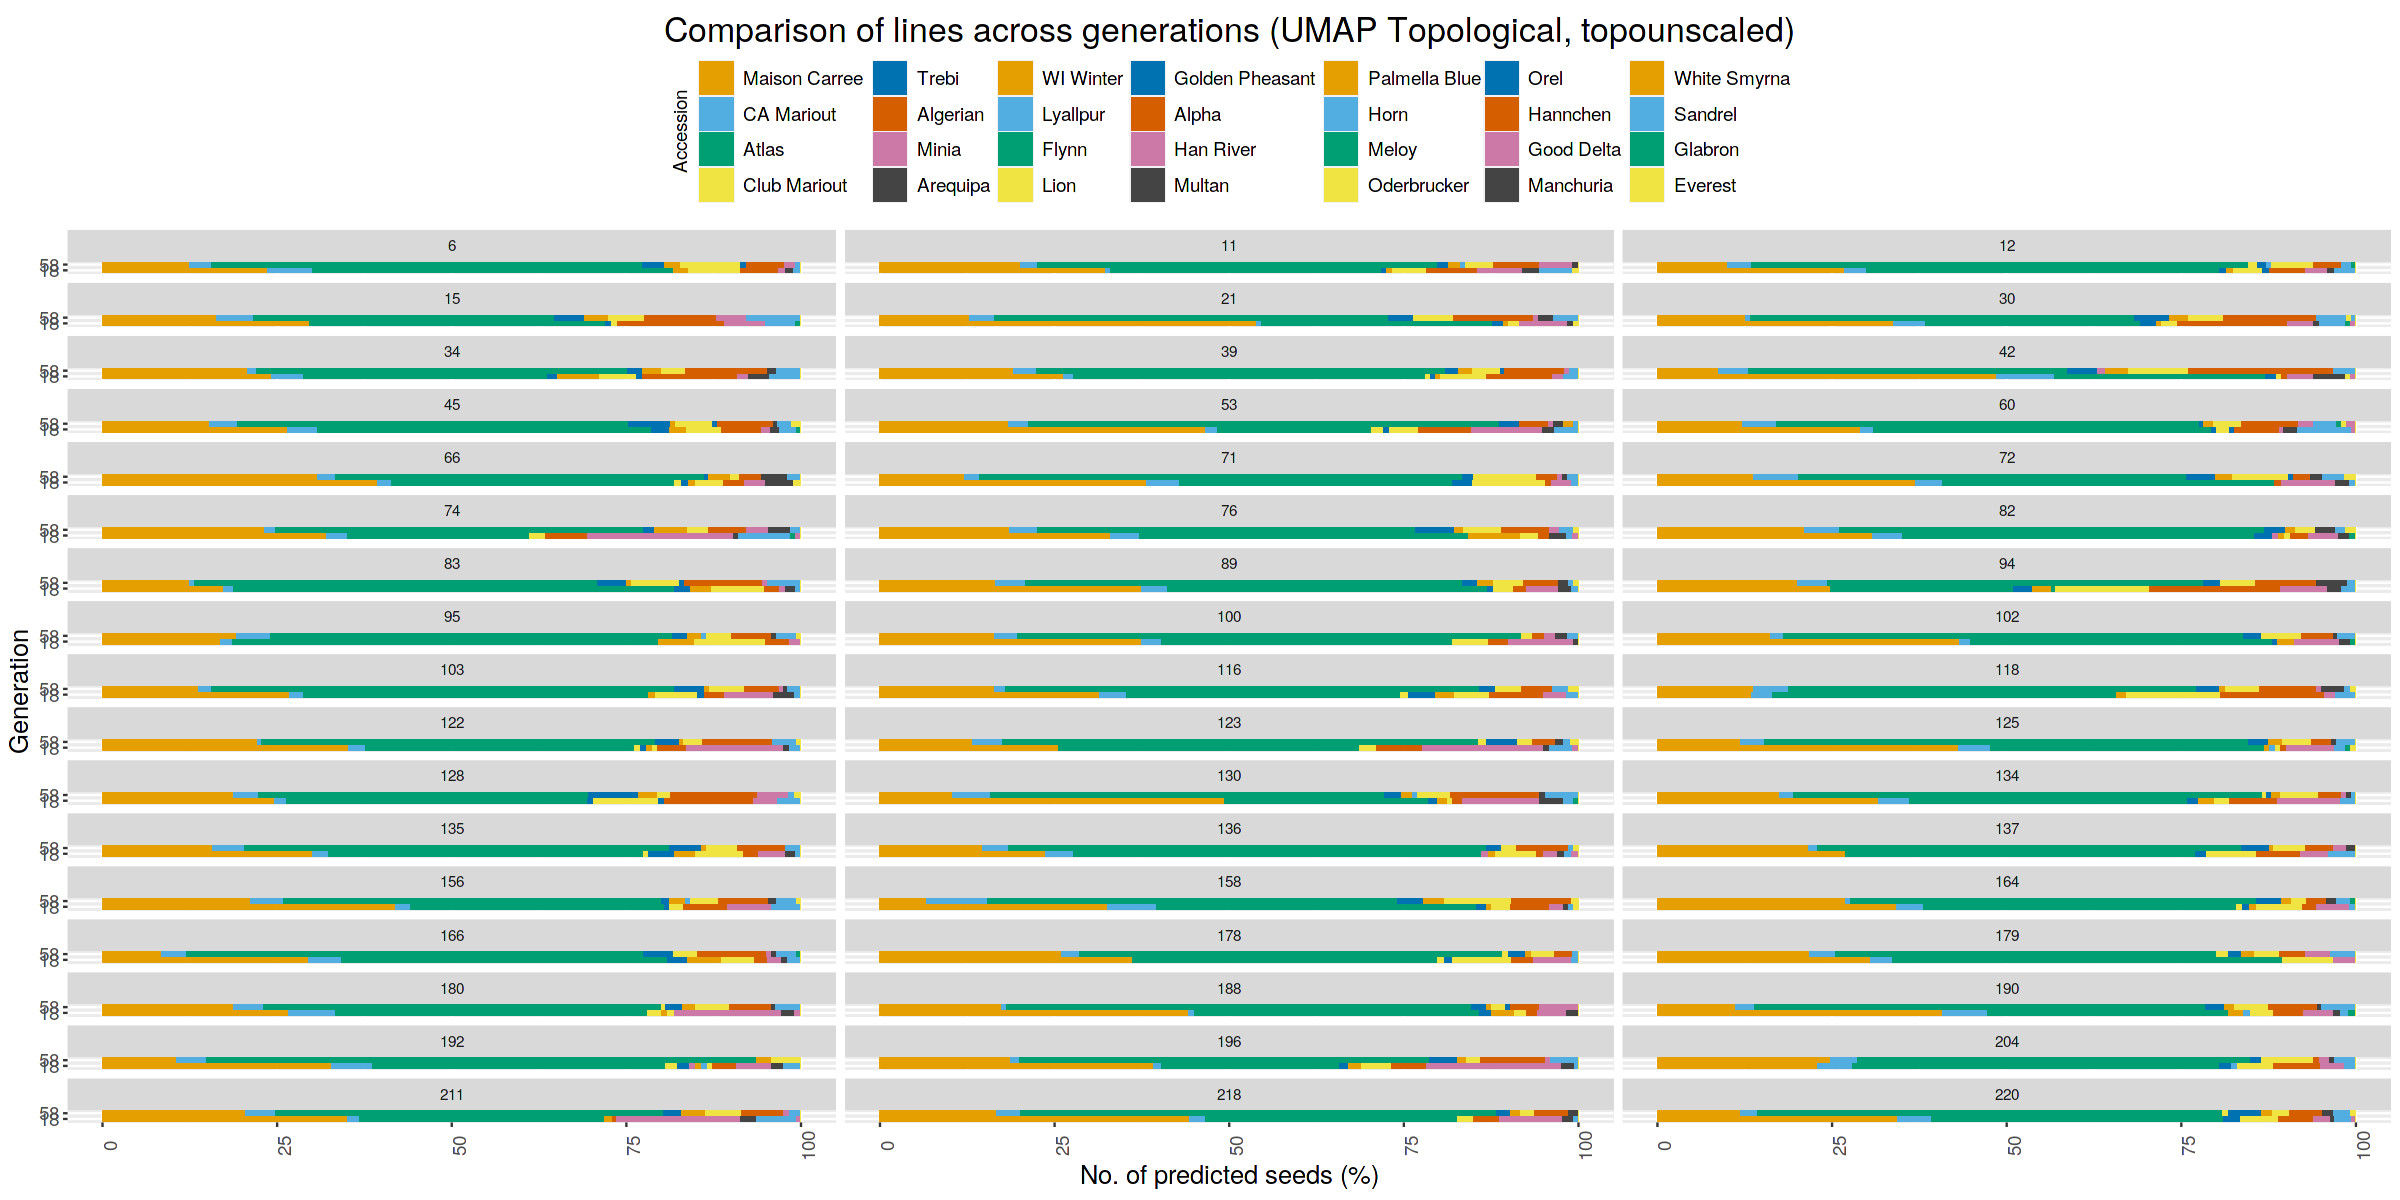

In [190]:
titlename <- paste('Comparison of lines across generations (UMAP ', 
                    stringr::str_to_title(info_type), ', ', 
                    scaled, ')', sep='')

p <- ggplot2::ggplot(dgm, aes(y=Gen, x=Percentage)) +
    geom_col(aes(fill=Line), position = position_stack(reverse = TRUE)) +
    facet_wrap(facet=vars(Selection), ncol=3) +
    scale_fill_manual(values = fcolors, guide = guide_legend(ncol = 7)) +
    theme(plot.title = element_text(hjust = 0.5, vjust = 0, size=20),
            axis.text.x = element_text(size = 11, angle=90),
            #axis.text.x = element_blank(),
            axis.text.y = element_text(size = 11),
            axis.title = element_text(size=15),
            legend.text = element_text(size=11),
            legend.key.size = unit(0.75, 'cm'),
            legend.title = element_text(angle=90, vjust=0.5, hjust=0.5),
            legend.position = "top"
            ) +
    xlab('No. of predicted seeds (%)') +
    ggtitle(titlename) +
    ylab('Generation') +
    labs(fill = "Accession")
p

In [191]:
w = 11
h = 16
filename <- paste('comparison_lines_',info_type,'_',scaled,'_d',d,'_T',TT,'_vert', sep='')
print(filename)
ggplot2::ggsave(paste(filename, '.pdf', sep=''), plot=p, device='pdf', width=w, height=h)
ggplot2::ggsave(paste(filename, '.png', sep=''), plot=p, device='png', width=w, height=h)

[1] "comparison_lines_topological_topounscaled_d158_T16_vert"
